# 线性回归
线性回归输出是一个连续值，因此适用于回归问题。回归问题在实际中很常见，如预测房屋价格、气温、销售额等连续值的问题。**与回归问题不同，分类问题中模型的最终输出是一个离散值。我们所说的图像分类、垃圾邮件识别、疾病检测等输出为离散值的问题都属于分类问题的范畴。softmax回归则适用于分类问题。**

房价预测问题，回归
$\hat y=x_1w_1+x_2w_2+b$

[损失函数讲解](https://tangshusen.me/Dive-into-DL-PyTorch/#/chapter03_DL-basics/3.1_linear-regression)

在求数值解的优化算法中，小批量随机梯度下降（mini-batch stochastic gradient descent）在深度学习中被广泛使用。它的算法很简单：先选取一组模型参数的初始值，如随机选取；接下来对参数进行多次迭代，使每次迭代都可能降低损失函数的值。在每次迭代中，先随机均匀采样一个由固定数目训练数据样本所组成的小批量（mini-batch）B
B
B，然后求小批量中数据样本的平均损失有关模型参数的导数（梯度），最后用此结果与预先设定的一个正数的乘积作为模型参数在本次迭代的减小量。


## 矢量计算表达式
在模型训练或预测时，我们常常会同时处理多个数据样本并用到矢量计算。在介绍线性回归的矢量计算表达式之前，让我们先考虑对两个向量相加的两种方法。

下面先定义两个1000维的向量。

In [1]:
import torch
from time import time

a=torch.ones(1000)
b=torch.ones(1000)

这是生成了两个1000维的向量，可以直接使用加法进行矢量加和

In [2]:
start=time()
d=a+b
print(d)

print(time()-start)

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 

In [3]:
a=torch.ones(4)
b=10
print(a+b)

tensor([11., 11., 11., 11.])


# 线性回归的实现
使用Tensor和autograd来实现线性回归训练

In [4]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

## 生成数据集
训练的样本数1000个，特征数（输入个数）为2，使用$\omega = [2,-3.4]^T$和偏差b=4.2，一个随机噪声ϵ来生成标签$$y=X\omega+b+ϵ $$

In [5]:
#生成数据集
num_inputs=2
num_examples=1000
true_w=[2,-3.4]
true_b=4.2
features=torch.randn(num_examples,num_inputs,dtype=torch.float32)
labels=true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b   #线性回归的方程，第一个参数乘以第一列（第一个特征），第二个参数乘第二列（第二个特征）

#这里是在数据集上加一个均值为0，标准差为0.01的正态分布，用来产生干扰。
labels+=torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

In [6]:
print(features[0],labels[0])    #特征是1000*2维的，随机产生的，labels是通过计算得到的，1000*1

tensor([1.1460, 0.7055]) tensor(4.0948)


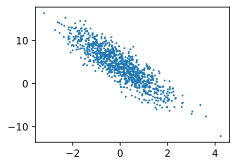

In [34]:
def use_svg_display():
    #矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize']=figsize

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)


##  读取数据
在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。

In [8]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        #这句话的意思是选择从i到i+batchsize大小的slice，如果到了最后，就选择i到num_examples的切片
        yield  features.index_select(0, j), labels.index_select(0, j)   #选择切片返回，同时程序停止


> 上一句话里面的处理最后的方法很重要！

In [9]:
batch_size=10

for X,y in data_iter(batch_size, features, labels):
    print(X,y)
    break

tensor([[ 1.4118,  0.4913],
        [-1.8346, -1.8266],
        [-0.9159,  1.9039],
        [-1.1458, -1.1053],
        [-1.1928, -0.0610],
        [ 0.5247,  0.7231],
        [-0.0774,  0.0776],
        [ 1.1778, -0.7054],
        [ 0.5779,  1.3503],
        [ 0.3090, -0.1262]]) tensor([ 5.3509,  6.7259, -4.1152,  5.6746,  2.0130,  2.7853,  3.7785,  8.9548,
         0.7714,  5.2498])


带yield的函数是一个生成器，而不是一个函数了，这个生成器有一个函数就是next函数，next就相当于“下一步”生成哪个数，这一次的next开始的地方是接着上一次的next停止的地方执行的，所以调用next的时候，生成器并不会从foo函数的开始执行，只是接着上一步停止的地方开始，然后遇到yield后，return出要生成的数，此步就结束。

执行到yield的时候，程序会暂停，并且返回后面的值，就停在那里了！

## 定义模型和损失函数
定义模型，初始化模型参数。权重的初始化成均值为0，标准差为0.01，偏差bias初始化为0

In [13]:
w=torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float32)
b=torch.zeros(1,dtype=torch.float32)

In [14]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

In [15]:
def linreg(X,w,b):
    return torch.mm(X,w)+b

In [16]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2
    # y是真实值，转变成为预测的尺寸才能进行运算。

In [18]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data，否则就会梯度回传。计算回梯度之后，用学习率乘梯度除batch_size


在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征X和标签y），通过调用反向函数backward计算小批量随机梯度，并调用优化算法sgd迭代模型参数。由于我们之前设批量大小batch_size为10，每个小批量的损失l的形状为(10, 1)。回忆一下自动求梯度一节。由于变量l并不是一个标量，所以我们可以调用.sum()将其求和得到一个标量，再运行l.backward()得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍data_iter函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [28]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))


epoch 1, loss 0.000050
epoch 2, loss 0.000050
epoch 3, loss 0.000050


In [27]:
print(true_w, '\n', w)
print(true_b, '\n', b)


[2, -3.4] 
 tensor([[ 1.9988],
        [-3.3995]], requires_grad=True)
4.2 
 tensor([4.2008], requires_grad=True)


# 线性回归简洁实现
首先还是生成数集


In [54]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)#生成的特征，输入
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)


In [55]:
import torch.utils.data as Data

batch_size=10
#训练数据的特征和标签结合函数

dataset=Data.TensorDataset(features,labels)
#随机读取小批量

data_iter=Data.DataLoader(dataset,batch_size,shuffle=True)


In [56]:
for X,y in data_iter:   #里面放的都是一个batch大小的数据
    print(X,y)
    break

tensor([[ 1.3671,  0.0585],
        [-0.4872, -0.4865],
        [ 0.1512, -0.6602],
        [-1.6128, -0.1708],
        [-1.4332, -0.8732],
        [-0.4240, -0.2832],
        [-1.4761, -2.1400],
        [-1.5189, -1.0548],
        [ 1.0859, -1.3727],
        [-1.8080,  0.5064]]) tensor([ 6.7361,  4.8826,  6.7588,  1.5545,  4.2978,  4.3193,  8.5294,  4.7535,
        11.0532, -1.1353])


使用torch.nn来导入神经网络层。导入torch.nn模块。实际上，“nn”是neural networks（神经网络）的缩写。顾名思义，该模块定义了大量神经网络的层。之前我们已经用过了autograd，而nn就是利用autograd来定义模型。nn的核心数据结构是Module，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承nn.Module，撰写自己的网络/层。**一个nn.Module实例应该包含一些层以及返回输出的前向传播（forward）方法。** 下面先来看看如何用nn.Module实现一个线性回归模型。

In [57]:
import torch.nn as nn

In [58]:

class LenearNet(nn.Module):
    def __init__(self,n_feature):
        super(LenearNet,self).__init__()
        self.linear = nn.Linear(n_feature,1)    #输入数量为n，输出为1，输入两维。
    def forward(self,x):
        y=self.linear(x)#输入x，输出一维
        return y

net=LenearNet(num_inputs)
print(net)


LenearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


也可以打印网络里面所有可以训练的参数，使用nn.parameters()函数

In [59]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0786, -0.4613]], requires_grad=True)
Parameter containing:
tensor([-0.5805], requires_grad=True)


作为一个单层神经网络，线性回归输出层中的神经元和输入层中各个输入完全连接。因此，线性回归的输出层又叫全连接层。

> torch.nn仅支持一个batch的输入，不支持单个的一维输入。如果存在一维向量输入则需要使用`input.unsqueeze(0)`来进行升维操作。里面的参数给的是升维降维的具体维数。[学习地址](https://blog.csdn.net/flysky_jay/article/details/81607289)

## 初始化模型参数

In [60]:
from torch.nn import init

init.normal_(net.linear.weight,mean=0,std=0.01)
init.constant_(net.linear.bias,val=0)

# net[0]的写法只有在modulelist或者sequential的时候才可以用

Parameter containing:
tensor([0.], requires_grad=True)

In [66]:
loss=torch.nn.functional.mse_loss #优化算法，是nn.Module的子类

深度学习训练模型报错：RuntimeError: Boolean value of Tensor with more than one value is ambiguous
原因：

loss = loss_func(out, label)

解决方案一：```criteria = nn.CrossEntropyLoss() ```
              ```  loss = criteria(out, label)```

解决方案二：``loss = torch.nn.functional.cross_entropy(out, label)``

[原文链接](https://blog.csdn.net/m13526413031/article/details/116426016)

优化算法

In [67]:
import torch.optim as optim

optimizer=optim.SGD(net.parameters(),lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


调整学习率可以修改optimizer.param_groups的学习率

In [73]:
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr']*=0.1

In [74]:
print(optimizer.param_groups)

[{'params': [Parameter containing:
tensor([[ 1.6846, -2.8550]], requires_grad=True), Parameter containing:
tensor([3.5387], requires_grad=True)], 'lr': 0.03, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}]


## 模型训练

In [75]:
num_epochs=3
for epoch in range(1,num_epochs+1):
    for X,y in data_iter:
        output=net(X)
        l=loss(output,y.view(-1,1))     #注意，-1指的是第一维不确定，通过第二维的大小来确定第一维的大小
        optimizer.zero_grad() #梯度清空
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch,l.item()))


epoch 1, loss: 0.000090
epoch 2, loss: 0.000126
epoch 3, loss: 0.000104


In [76]:
print(true_w, net.linear.weight)
print(true_b, net.linear.bias)

[2, -3.4] Parameter containing:
tensor([[ 2.0001, -3.4000]], requires_grad=True)
4.2 Parameter containing:
tensor([4.2005], requires_grad=True)
